# Pytorch Demo 



## 1. Import packages

In [10]:
import os
import time
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # 基础数据处理

from random import sample # 随机采样

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Pytorch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms
# import scipy # if ImageNet

from tqdm.notebook import tnrange
from tqdm.notebook import tqdm
import time

1.4.0


## 2. Dataset
All datasets are saved in `'../dataset/'`
For MNIST, CIFAR10 and CIFAR100, you can download it by setting `download=True` in `torchvision.datasets.XXXX`.

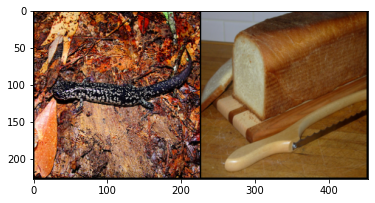

In [68]:
# Test the tqdm
# for i in tnrange(2, desc='1st loop'):
#     for j in tnrange(50,desc='2nd loop'):
#         time.sleep(0.01)
dataName = 'MNIST' 

train_trainsform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2),
                                       transforms.ToTensor()])
val_trainsform = train_trainsform
def get_TrainVal_dataset(dataName,trian_transform,val_transform):
    if dataName == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(
            root='../dataset/',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.MNIST(
            root='../dataset/',
            train=False,
            transform=val_transform,
            download=False
        )
        return train_dataset, val_dataset
    elif dataName == 'CIFAR10':
        train_dataset = torchvision.datasets.CIFAR10(
            root='../dataset/cifar10',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.CIFAR10(
                root='../dataset/cifar10',
                train=False,
                transform=val_transform,
                download=False
        )
        return train_dataset, val_dataset
    elif dataName =='CIFAR100':
        train_dataset = torchvision.datasets.CIFAR100(
            root='/data/datasets/',
            train=True,
            transform=trian_transform,
            download=False
        )
        val_dataset = torchvision.datasets.CIFAR100(
            root='/data/datasets/',
            train=False,
            transform=val_transform,
            download=False
        )
        return train_dataset, val_dataset
    elif dataName == 'ImageNet':
        train_dataset = torchvision.datasets.ImageFolder(
            root = '../dataset/ImageNet/train',
            transform = trian_transform,
        )
        val_dataset = torchvision.datasets.ImageFolder(
            root = '../dataset/ImageNet/val',
            transform = val_transform,
        )
        return train_dataset, val_dataset
    else:
        msg = ("Wrong dataset name, choose one from \'MNIST\', \'CIFAR10\', \'CIFAR100\' and \'ImageNet\'!")
        raise RuntimeError(msg)



trainset, valset = get_TrainVal_dataset('ImageNet',train_trainsform,val_trainsform)

# Visualization
dl = DataLoader(trainset, batch_size = 2, shuffle = True, num_workers = 8) 

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(dl)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
del dl

In [69]:
import torch.nn as nn

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 200
# NUM_EPOCHS = 200

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 1000

# Other
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('We will implement this model on:',DEVICE,'!')

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True, num_workers = 8)

# Checking datasets
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

We will implement this model on: cuda !
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])


In [51]:
switch["MNIST"]